# Проект Detection, сценарий 2
Проект подразумевает собой написание полного пайплайна обучения и измерения метрик

###### Проект выполнила: Измайлова Юлия Андреевна, ник в телеграме: @alepouzs

Для обучения был выбран детектор SSDLiteMobileNet_V3, в качестве датасета был выбран датасет c Kaggle [farm animals dataset](https://www.kaggle.com/datasets/antoreepjana/animals-detection-images-dataset).

In [1]:
import numpy as np 
import pandas as pd 
import glob
from tqdm import tqdm
import os
import cv2
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style='darkgrid', font_scale=1.2)

import torch
import torchvision
import torchvision.transforms as tt
from torch.utils.data import Dataset
import albumentations as A
from albumentations.pytorch import ToTensorV2

torch.set_default_dtype(torch.float64)

import warnings
warnings.filterwarnings("ignore")

image_size = 256
batch_size = 12

Выполним загрузку датасета и посмотрим, сколько классов в каждой папке.

In [2]:
#!pip install opendatasets
#import opendatasets as od
#od.download('https://www.kaggle.com/datasets/antoreepjana/animals-detection-images-dataset')

In [3]:
train_subdir=glob.glob("animals-detection-images-dataset\\train\\*")
test_subdir=glob.glob("animals-detection-images-dataset\\test\\*")

train_classes=[os.path.basename(pp) for pp in train_subdir]
test_classes=[os.path.basename(pp) for pp in test_subdir]

print("There is %d classes in train dataset, and %d classes in test dataset"%(len(train_classes), len(test_classes)))

There is 80 classes in train dataset, and 80 classes in test dataset


Проверим, совпадают ли названия классов в папке train и test.

In [4]:
train_classes==test_classes

True

Посчитаем, сколько элементов каждого класса присутствует в датасете и приведем гистограмму распределения данных.

In [5]:
train_image_counts={os.path.basename(pp):[len(glob.glob(os.path.join(pp, "*.jpg")))] for pp in train_subdir}
test_image_counts={os.path.basename(pp):[len(glob.glob(os.path.join(pp, "*.jpg")))] for pp in test_subdir}


train_data_df = pd.DataFrame(train_image_counts, index=["train"]).transpose()
test_data_df = pd.DataFrame(test_image_counts, index=["test"]).transpose()
all_data_df=train_data_df.copy()
all_data_df["test"]=test_data_df
all_data_df.head()

,train,test
Bear,87,39
Brown bear,108,39
Bull,47,73
Butterfly,1875,170
Camel,67,27


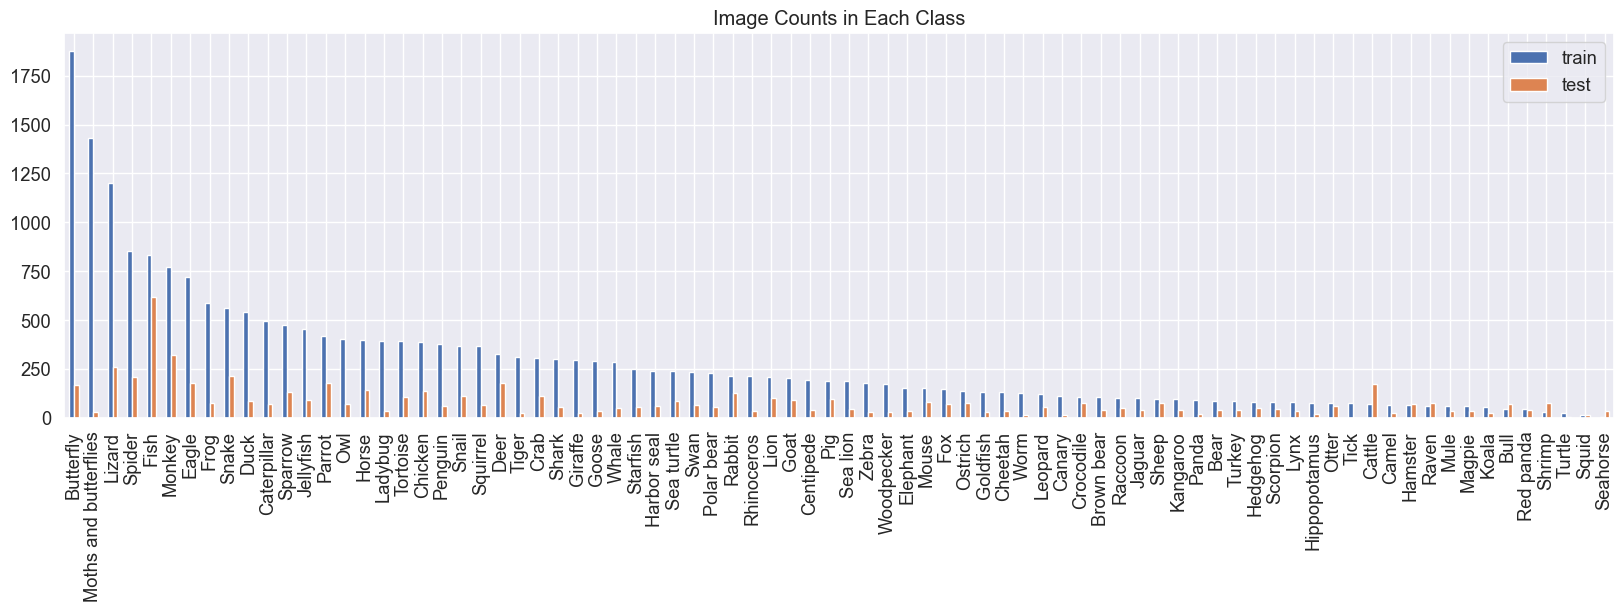

In [6]:
all_data_df=all_data_df.sort_values(by=["train","test"], ascending=False)
all_data_df.plot(kind="bar", legend=True, figsize=(20,5), title="Image Counts in Each Class");

In [7]:
import utils

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

num_classes = len(train_classes)

Напишем класс AnimalsDataset для более удобной работы с ним.

In [8]:
class AnimalsDataset(torch.utils.data.Dataset):
    def __init__(self, root):
        self.root = root
        self.imgs, self.boxes = [], []
        
        for item in glob.glob(os.path.join(root, "*")):
            self.imgs.extend(glob.glob(os.path.join(item,"*"))[:-1])
            self.boxes.extend(glob.glob(os.path.join(item, "Label\\*")))

    def __getitem__(self, idx):
        # load images and boxes
        img = Image.open(self.imgs[idx]).convert("RGB")
        
        # get bounding box coordinates
        boxes, labels = [], []
        with open(self.boxes[idx], 'r') as f:
            for i in f.readlines():
                i = i.strip().split()
                labels.append(train_classes.index(" ".join(i[0:len(i) - 4])))
                boxes.append(list(map(float, i[len(i) - 4:])))

        target = {"boxes" : torch.as_tensor(boxes, dtype=torch.float64), 
                 "labels" : torch.as_tensor(labels, dtype=torch.int64)}
            
        return torch.as_tensor(np.array(img) / -255, dtype=torch.double).permute(2, 0, 1), target

    def __len__(self):
        return len(self.imgs)

In [9]:
def get_image(img, boxes, labels, thickness = 3, font_size = 1.1):
    img = np.array(tt.ToPILImage()(img * 255))
    for i in np.arange(0, len(boxes)):
        img = cv2.rectangle(img, (int(boxes[i][0]), int(boxes[i][1])), 
                            (int(boxes[i][2]), int(boxes[i][3])), (0,0,255), thickness)
        img = cv2.putText(img, train_classes[labels[i]], (int(boxes[i][0]), int(boxes[i][1])-5), 
                          cv2.FONT_HERSHEY_SIMPLEX, font_size, (0, 0, 255), thickness)
    return img

In [10]:
def show_image(img, boxes, labels, thickness = 3, font_size = 1.1):
    plt.imshow(get_image(img, boxes, labels, thickness = 3, font_size = 1.1))
    plt.show()

In [11]:
train_path = os.path.join(os.getcwd(), "train")
train_dataset = AnimalsDataset(train_path)

test_path = os.path.join(os.getcwd(), "test")
test_dataset = AnimalsDataset(test_path)

Нарисуем пример изображения из обучающей выборки с разметкой на нем

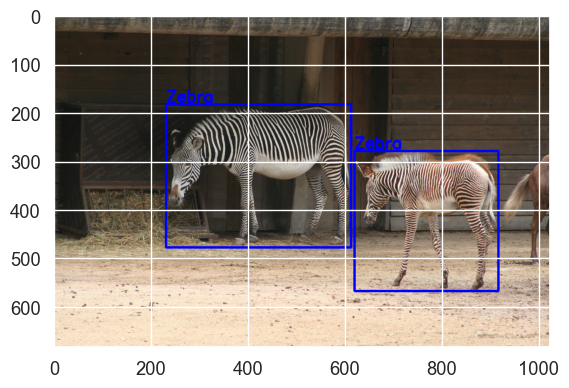

In [12]:
show_image(train_dataset[-178][0], train_dataset[-178][1]["boxes"], train_dataset[-178][1]["labels"], 3, 1)

И еще немного картинок из обучающей выборки

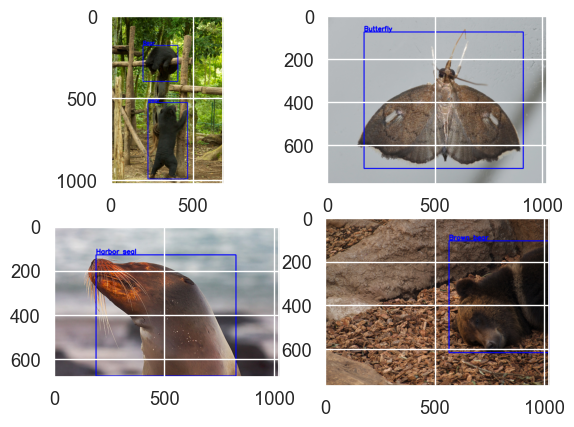

In [13]:
fig, axes = plt.subplots(nrows=2, ncols=2)

axes[0,0].imshow(get_image(train_dataset[25][0], train_dataset[25][1]["boxes"], train_dataset[25][1]["labels"], 3, 1))

axes[0,1].imshow(get_image(train_dataset[1000][0], train_dataset[1000][1]["boxes"], train_dataset[1000][1]["labels"], 3, 1))

axes[1,0].imshow(get_image(train_dataset[8501][0], train_dataset[8501][1]["boxes"], train_dataset[8501][1]["labels"], 3, 1))

axes[1,1].imshow(get_image(train_dataset[112][0], train_dataset[112][1]["boxes"], train_dataset[112][1]["labels"], 3, 1))
plt.show()

In [14]:
def collate(batch):
    return tuple(zip(*batch))

Для последующего расчета метрик задачи Object Detection используем метрику IOU.

In [15]:
def get_iou_torch(ground_truth, pred):
    # Coordinates of the area of intersection.
    iou = torch.zeros(len(ground_truth), np.max([len(gt) for gt in ground_truth]))
    i = 0

    for o, (gt, pr) in enumerate(zip(ground_truth, pred)):
        iou_tmp = []
        for i in np.arange(0, len(gt), 1):
            for j in np.arange(0, len(pr), 1):
                ix1 = torch.max(gt[i][0], pr[j][0])
                iy1 = torch.max(gt[i][1], pr[j][1])
                ix2 = torch.min(gt[i][2], pr[j][2])
                iy2 = torch.min(gt[i][3], pr[j][3])
                # Intersection height and width.
                i_height = torch.max(iy2 - iy1 + 1, torch.tensor(0.))
                i_width = torch.max(ix2 - ix1 + 1, torch.tensor(0.))

                area_of_intersection = i_height * i_width

                # Ground Truth dimensions.
                gt_height = gt[i][3].item() - gt[i][1].item() + 1
                gt_width = gt[i][2].item() - gt[i][0].item() + 1

                # Prediction dimensions.
                pd_height = pr[j][3].item() - pr[j][1].item() + 1
                pd_width = pr[j][2].item() - pr[j][0].item() + 1

                area_of_union = gt_height * gt_width + pd_height * pd_width - area_of_intersection

                iou_tmp.append(area_of_intersection / area_of_union)
        iou_tmp = sorted(iou_tmp, reverse=True)
        for i in np.arange(0, len(gt), 1):
            iou[o][i] = iou_tmp[i]
    return iou

Далее перейдем к обучению модели. Детектор в режиме train() возвращает loss для задачи классификации и регрессии, поэтому loss = classification_loss + regression_loss для каждого батча, а затем мы берем среднее значение loss.

In [16]:
def train_one_epoch(model, optimizer, data_loader, device, epoch):
    model.train()
    losses = []

    lr_scheduler = None
    if epoch == 0:
        warmup_factor = 1.0 / 1000
        warmup_iters = min(1000, len(data_loader) - 1)

        lr_scheduler = torch.optim.lr_scheduler.LinearLR(
            optimizer, start_factor=warmup_factor, total_iters=warmup_iters
        )

    for images, targets in data_loader:
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        loss = sum(loss for loss in loss_dict.values())
        
        losses.append(loss.cpu().detach().numpy())
        optimizer.zero_grad()

        loss.backward()
        optimizer.step()
            
        if lr_scheduler is not None:
            lr_scheduler.step()
    return np.mean(losses)

Теперь напишем функции валидации модели. 

In [17]:
elements_per_class = {i : v[0] for i, v in enumerate(test_image_counts.values())}

In [19]:
def get_metrics(targets, outputs):
    thresholds = np.arange(0.2, 0.9, 0.05)
    counts = np.unique([target['labels'][0].item() for target in targets], return_counts=True)[1]
    metrics_dict = {}
    j = 0

    for i in np.arange(0, len(counts), 1):
        tmp_t, tmp_o = targets[j : j + counts[i]], outputs[j : j + counts[i]]
        j = j + counts[i]
        iou = get_iou_torch([d["boxes"] for d in tmp_t], [d["boxes"] for d in tmp_o])
        scores = [d["scores"] for d in tmp_o]
        scores_iou = []
        for k in np.arange(0, len(scores), 1):
            for m in np.arange(0, len(scores[k]), 1):
                scores_iou.append([scores[k][m], iou[k][m]])
        scores_iou = sorted(scores_iou, key=lambda x: x[0], reverse=True)

        recall, precision = [], []
        target_iou = [score_iou[1] for score_iou in scores_iou]

        for threshold in thresholds:
            TP, FP = [], []
            for elem in target_iou:
                TP.append(int(elem >= threshold))
                FP.append(int((elem < threshold) & (elem > 0)))
            TP_cumsum = torch.cumsum(torch.Tensor(np.array(TP)), dim=0)
            FP_cumsum = torch.cumsum(torch.Tensor(np.array(FP)), dim=0)

            recall.append(TP_cumsum / len(target_iou))

            precision.append(TP_cumsum / (TP_cumsum + FP_cumsum + 1e-6))

        recall = np.array(recall)
        precision = np.array(precision)

        f1 = 2 * (precision[6] * recall[6]) / (precision[6] + recall[6])  
        f1[f1.isnan()] = 0

        AP = np.mean([torch.trapz(precision[n], recall[n]) for n in np.arange(0, len(precision), 1)])

        metrics_dict[tmp_t[0]['labels'][0]] = [torch.mean(recall[6]), torch.mean(precision[6]), torch.mean(f1), AP]
        
    return metrics_dict

In [20]:
def evaluate(model, data_loader):
    losses = []
    metrics_dict = {i : []  for i in list(elements_per_class.keys())}
    images, targets = [], []

    for images, targets in data_loader:
        images = [image.to(device) for image in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        if len(images) == batch_size:
            model.train()
            with torch.no_grad():
                val_loss_dict = model(images, targets)
            loss = sum(loss for loss in val_loss_dict.values())

            losses.append(loss.cpu().detach().numpy())

        targets = [{k: v.to("cpu") for k, v in t.items()} for t in targets]

        model.eval()
        with torch.no_grad():
            outputs = [{k: v.to("cpu") for k, v in t.items()} for t in model(images)]
        
        h = []
        for i, output in enumerate(outputs):
            boxes, labels = [], []
            scores = sorted(output['scores'], reverse=True)[0:len(targets[i]['boxes'])]
            for j in scores:
                ind = (output['scores'] == j).nonzero(as_tuple=True)[0]
                boxes.extend(output['boxes'][ind])
                labels.extend(output['labels'][ind])
            h.append({'boxes' : boxes, 'labels' : labels, 'scores' : scores})

        batch_metrics = get_metrics(targets, h) 
        
        for label, metrics in batch_metrics.items():
            metrics_dict[label.item()].append(metrics)
 
    return np.mean(losses), metrics_dict        

In [21]:
torch.cuda.empty_cache()
import gc
#del variables
gc.collect()

21011

In [22]:
train_data_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn = collate)
test_data_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn = collate)

In [23]:
 def resize_boxes(boxes, original_size, new_size):
    ratios = [torch.tensor(s, dtype=torch.float32, device=boxes.device) / 
              torch.tensor(s_orig, dtype=torch.float32, device=boxes.device)
              for s, s_orig in zip(new_size, original_size)]

    ratio_height, ratio_width = ratios
    xmin, ymin, xmax, ymax = boxes.unbind(1)

    xmin = xmin * ratio_width
    xmax = xmax * ratio_width
    ymin = ymin * ratio_height
    ymax = ymax * ratio_height
    return torch.stack((xmin, ymin, xmax, ymax), dim=1)

В самой модели реализованы аугментации, поэтому мы их заменим с помощью своего класса Transform с целью исследования.

In [24]:
class ImageList:
    def __init__(self, tensors, image_sizes):
        self.tensors = tensors
        self.image_sizes = image_sizes

    def to(self, device):
        cast_tensor = self.tensors.to(device)
        return ImageList(cast_tensor, self.image_sizes)

class Transform(torch.nn.Module):
    def __init__(self, size, mean, std):
        super().__init__()
        self.size = size
        self.mean = mean
        self.std = std
        self.transform = A.Compose([A.Resize(size, size), A.Normalize(mean=mean, std=std)],
                                   bbox_params=A.BboxParams(format='pascal_voc', label_fields=['class_labels']))
        
    def forward(self, images, targets=None):
        result_images, result_targets, image_sizes = [], [], []
        
        if self.training:
            for i in np.arange(0, len(images), 1):
                result_images.append(self.transform(image = np.array(tt.ToPILImage()(images[i].cpu() * 255)), 
                                        bboxes = targets[i]["boxes"].cpu(), class_labels = targets[i]["labels"]))

                result_targets.append({"boxes" : torch.tensor(result_images[i]["bboxes"]).to(device), 
                                       "labels" : targets[i]["labels"]})
                result_images[i] = tt.ToTensor()(result_images[i]["image"]).numpy()
                image_sizes.append((images[i].shape[1], images[i].shape[2]))
        else:
            for i in np.arange(0, len(images), 1):
                result_images.append(self.transform(image = np.array(tt.ToPILImage()(images[i].cpu() * 255)),
                                    bboxes = [], class_labels = []))
                result_targets.append({"boxes" : [], 
                                       "labels" : []})
                result_images[i] = tt.ToTensor()(result_images[i]["image"]).numpy()
                image_sizes.append((result_images[i].shape[1], result_images[i].shape[2]))
        
            result_targets = None
        tmp = ImageList(torch.tensor(np.array(result_images), dtype=torch.double).to(device), image_sizes) 
        return tmp, result_targets
    
    def __repr__(self):
        format_string = f"{self.__class__.__name__}("
        format_string += f"\n    Resize(height={self.size}, width={self.size})"
        format_string += f"\n    Normalize(mean={self.mean}, std={self.std})"
        format_string += "\n)"
        return format_string
    
    def postprocess(self, result, image_shapes, original_image_sizes):
        if self.training:
            return result
        for i, (pred, im_s, o_im_s) in enumerate(zip(result, image_shapes, original_image_sizes)):
            boxes = pred["boxes"]
            boxes = resize_boxes(boxes, im_s, o_im_s)
            result[i]["boxes"] = boxes
        return result

In [25]:
torch.cuda.empty_cache()

import gc
#del variables
gc.collect()

0

Теперь обучим модель, заменяя Transform и перенося все на GPU.

In [26]:
model = torchvision.models.detection.ssdlite320_mobilenet_v3_large(weights=torchvision.models.detection.SSDLite320_MobileNet_V3_Large_Weights.DEFAULT)
#model.load_state_dict(torch.load("SSDLiteMobNet.pth"))
model.transform = Transform(image_size, [0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
model.to(device)

SSD(
  (backbone): SSDLiteFeatureExtractorMobileNet(
    (features): Sequential(
      (0): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
          (2): Hardswish()
        )
        (1): InvertedResidual(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
              (1): BatchNorm2d(16, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
              (2): ReLU(inplace=True)
            )
            (1): Conv2dNormActivation(
              (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
              (1): BatchNorm2d(16, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
            )
          )
        )
        (2): Invert

In [27]:
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

In [28]:
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

In [29]:
# num_epochs = 3 

In [34]:
#train_losses, val_losses, val_metrics = [], [], []
for epoch in tqdm(range(12, 24)):
    print(f"Epoch: [{epoch}]")
    mAP = 0
    train_loss = train_one_epoch(model, optimizer, train_data_loader, device, epoch)
    train_losses.append(train_loss)
    lr_scheduler.step()
    
    torch.save(model.state_dict(), f"SSDLiteMobNet_{epoch}.pth")
    
    val_loss, metrics = evaluate(model, test_data_loader)
    
    for k, v in metrics.items():
        metrics[k] = np.mean(v, axis=0)

    val_losses.append(val_loss)
    val_metrics.append(metrics)
    
    
    print(f"train loss: {train_loss}, val loss: {val_loss}")
    #print(f"val loss: {val_loss}")
    
    print("{:<25} {:<10} {:<10} {:<10} {:<10}".format('class_id', 'recall', 'precision', 'f1', 'AP'));
    for k, v in metrics.items():
        mAP += np.round(v[3], 5)
        print("{:<25} {:<10} {:<10} {:<10} {:<10}".format(train_classes[k], np.round(v[0], 5), np.round(v[1], 5), np.round(v[2], 5), np.round(v[3], 5)));
    print("mAP: ", mAP.item() / num_classes)

  0%|                                                                                           | 0/12 [00:00<?, ?it/s]

Epoch: [12]


  8%|██████▌                                                                        | 1/12 [52:15<9:34:46, 3135.17s/it]

train loss: 2.452150156018239, val loss: 6.537125010971858
class_id                  recall     precision  f1         AP        
Bear                      0.53963    0.96901    0.64935    0.69482   
Brown bear                0.51829    0.95521    0.62573    0.82443   
Bull                      0.48191    0.91039    0.58686    0.6967    
Butterfly                 0.51028    0.95781    0.622      0.69734   
Camel                     0.5561     0.97339    0.66207    0.71953   
Canary                    0.5727     0.99173    0.68192    0.73772   
Caterpillar               0.53242    0.95661    0.63998    0.61638   
Cattle                    0.46372    0.87096    0.56191    0.64134   
Centipede                 0.49348    0.93883    0.60085    0.69029   
Cheetah                   0.53741    0.99852    0.65035    0.81539   
Chicken                   0.52954    0.97145    0.63883    0.78601   
Crab                      0.50846    0.92609    0.61348    0.74574   
Crocodile                 0.577

 17%|████████████▊                                                                | 2/12 [1:44:08<8:40:25, 3122.51s/it]

train loss: 2.4444920270392245, val loss: 6.536978934532841
class_id                  recall     precision  f1         AP        
Bear                      0.53963    0.96901    0.64935    0.69804   
Brown bear                0.51829    0.95521    0.62573    0.82619   
Bull                      0.47979    0.90766    0.58452    0.69304   
Butterfly                 0.51122    0.95862    0.62284    0.70014   
Camel                     0.5561     0.97339    0.66207    0.72046   
Canary                    0.5727     0.99173    0.68192    0.74903   
Caterpillar               0.53242    0.95661    0.63998    0.61534   
Cattle                    0.46586    0.87631    0.56501    0.64441   
Centipede                 0.49864    0.94551    0.60664    0.70041   
Cheetah                   0.53741    0.99852    0.65035    0.81698   
Chicken                   0.52954    0.97145    0.63883    0.78527   
Crab                      0.50846    0.92609    0.61348    0.74548   
Crocodile                 0.57

 25%|███████████████████▎                                                         | 3/12 [2:36:03<7:47:49, 3118.79s/it]

train loss: 2.447039918054492, val loss: 6.536912086355656
class_id                  recall     precision  f1         AP        
Bear                      0.53668    0.96592    0.64633    0.69067   
Brown bear                0.51829    0.95521    0.62573    0.82453   
Bull                      0.48111    0.90827    0.5857     0.69788   
Butterfly                 0.51088    0.95851    0.62258    0.69829   
Camel                     0.55507    0.9703     0.66053    0.72688   
Canary                    0.5727     0.99173    0.68192    0.75945   
Caterpillar               0.53143    0.95529    0.63884    0.61639   
Cattle                    0.46962    0.88194    0.56944    0.6514    
Centipede                 0.49348    0.93883    0.60085    0.69017   
Cheetah                   0.53741    0.99852    0.65035    0.81539   
Chicken                   0.52954    0.97145    0.63883    0.78524   
Crab                      0.50846    0.92609    0.61348    0.74699   
Crocodile                 0.577

 33%|█████████████████████████▋                                                   | 4/12 [3:28:18<6:56:41, 3125.20s/it]

train loss: 2.4450296000986897, val loss: 6.536919175267942
class_id                  recall     precision  f1         AP        
Bear                      0.53668    0.96592    0.64633    0.68793   
Brown bear                0.51829    0.95521    0.62573    0.82433   
Bull                      0.4812     0.9087     0.58585    0.70329   
Butterfly                 0.51198    0.95893    0.62342    0.70152   
Camel                     0.5561     0.97339    0.66207    0.73049   
Canary                    0.5727     0.99173    0.68192    0.75945   
Caterpillar               0.53143    0.95529    0.63884    0.62031   
Cattle                    0.46793    0.87756    0.56686    0.64629   
Centipede                 0.49348    0.93883    0.60085    0.69017   
Cheetah                   0.53741    0.99852    0.65035    0.81539   
Chicken                   0.52954    0.97145    0.63883    0.78509   
Crab                      0.50916    0.92692    0.61423    0.74749   
Crocodile                 0.57

 42%|████████████████████████████████                                             | 5/12 [4:20:13<6:04:10, 3121.54s/it]

train loss: 2.449015667180264, val loss: 6.536914549121675
class_id                  recall     precision  f1         AP        
Bear                      0.53668    0.96592    0.64633    0.68865   
Brown bear                0.52084    0.95832    0.62853    0.82868   
Bull                      0.482      0.91048    0.58695    0.69958   
Butterfly                 0.51329    0.96       0.62464    0.70543   
Camel                     0.55404    0.96876    0.65929    0.72142   
Canary                    0.5727     0.99173    0.68192    0.7483    
Caterpillar               0.53019    0.95215    0.637      0.61891   
Cattle                    0.46656    0.87685    0.56574    0.64672   
Centipede                 0.49348    0.93883    0.60085    0.69017   
Cheetah                   0.53741    0.99852    0.65035    0.81567   
Chicken                   0.53007    0.97273    0.63958    0.7866    
Crab                      0.50846    0.92609    0.61348    0.74603   
Crocodile                 0.577

 50%|██████████████████████████████████████▌                                      | 6/12 [5:12:21<5:12:22, 3123.72s/it]

train loss: 2.4443015256349145, val loss: 6.536898268696224
class_id                  recall     precision  f1         AP        
Bear                      0.53963    0.96901    0.64935    0.70168   
Brown bear                0.52084    0.95832    0.62853    0.82706   
Bull                      0.4812     0.9087     0.58585    0.6946    
Butterfly                 0.51193    0.95847    0.6232     0.7006    
Camel                     0.55404    0.96876    0.65929    0.71882   
Canary                    0.5727     0.99173    0.68192    0.75945   
Caterpillar               0.5292     0.95082    0.63587    0.61589   
Cattle                    0.46742    0.87612    0.56619    0.64538   
Centipede                 0.49348    0.93883    0.60085    0.69004   
Cheetah                   0.53741    0.99852    0.65035    0.81539   
Chicken                   0.52954    0.97145    0.63883    0.78614   
Crab                      0.50846    0.92609    0.61348    0.74695   
Crocodile                 0.57

 58%|████████████████████████████████████████████▉                                | 7/12 [6:04:11<4:19:57, 3119.42s/it]

train loss: 2.446487708431801, val loss: 6.536897078618466
class_id                  recall     precision  f1         AP        
Bear                      0.53963    0.96901    0.64935    0.69778   
Brown bear                0.51956    0.95683    0.62716    0.82587   
Bull                      0.48147    0.90907    0.58619    0.69647   
Butterfly                 0.51193    0.95805    0.623      0.70304   
Camel                     0.5561     0.97339    0.66207    0.72802   
Canary                    0.5727     0.99173    0.68192    0.75626   
Caterpillar               0.53242    0.95661    0.63998    0.61422   
Cattle                    0.46662    0.87415    0.56514    0.64406   
Centipede                 0.49348    0.93883    0.60085    0.69156   
Cheetah                   0.53741    0.99852    0.65035    0.81539   
Chicken                   0.52924    0.97111    0.63851    0.78508   
Crab                      0.50846    0.92609    0.61348    0.74653   
Crocodile                 0.578

 67%|███████████████████████████████████████████████████▎                         | 8/12 [6:56:02<3:27:46, 3116.73s/it]

train loss: 2.450890868502582, val loss: 6.536897099147497
class_id                  recall     precision  f1         AP        
Bear                      0.53963    0.96901    0.64935    0.69907   
Brown bear                0.51829    0.95521    0.62573    0.82399   
Bull                      0.47723    0.90393    0.58183    0.69      
Butterfly                 0.51122    0.95904    0.62304    0.69829   
Camel                     0.55404    0.96876    0.65929    0.71656   
Canary                    0.5727     0.99173    0.68192    0.74903   
Caterpillar               0.53143    0.95767    0.63963    0.61701   
Cattle                    0.46355    0.8697     0.56153    0.6386    
Centipede                 0.49864    0.94551    0.60664    0.69983   
Cheetah                   0.53741    0.99852    0.65035    0.81698   
Chicken                   0.52954    0.97145    0.63883    0.78514   
Crab                      0.50846    0.92609    0.61348    0.74508   
Crocodile                 0.577

 75%|█████████████████████████████████████████████████████████▊                   | 9/12 [7:47:42<2:35:34, 3111.45s/it]

train loss: 2.441400047013934, val loss: 6.536895670440013
class_id                  recall     precision  f1         AP        
Bear                      0.53494    0.96403    0.64452    0.69211   
Brown bear                0.51956    0.95683    0.62716    0.82607   
Bull                      0.48103    0.90793    0.58556    0.6993    
Butterfly                 0.51122    0.95904    0.62304    0.69858   
Camel                     0.55404    0.9666     0.65892    0.73052   
Canary                    0.5727     0.99173    0.68192    0.73772   
Caterpillar               0.53143    0.95529    0.63884    0.61822   
Cattle                    0.46738    0.87675    0.56627    0.64556   
Centipede                 0.49348    0.93883    0.60085    0.68988   
Cheetah                   0.53741    0.99852    0.65035    0.81698   
Chicken                   0.52924    0.97111    0.63851    0.78536   
Crab                      0.50846    0.92609    0.61348    0.74528   
Crocodile                 0.577

 83%|███████████████████████████████████████████████████████████████▎            | 10/12 [8:39:23<1:43:36, 3108.30s/it]

train loss: 2.4506400911985446, val loss: 6.536895626221396
class_id                  recall     precision  f1         AP        
Bear                      0.53963    0.96901    0.64935    0.69962   
Brown bear                0.51956    0.95683    0.62716    0.82541   
Bull                      0.47723    0.90393    0.58183    0.68897   
Butterfly                 0.51292    0.96117    0.62491    0.70505   
Camel                     0.55404    0.97016    0.65956    0.71922   
Canary                    0.5727     0.99173    0.68192    0.73772   
Caterpillar               0.53143    0.95529    0.63884    0.61902   
Cattle                    0.46378    0.87019    0.56185    0.63868   
Centipede                 0.49864    0.94551    0.60664    0.69959   
Cheetah                   0.53741    0.99852    0.65035    0.81698   
Chicken                   0.52954    0.97145    0.63883    0.78485   
Crab                      0.50846    0.92609    0.61348    0.74341   
Crocodile                 0.57

 92%|███████████████████████████████████████████████████████████████████████▌      | 11/12 [9:31:14<51:49, 3109.14s/it]

train loss: 2.4424448155684804, val loss: 6.536895539168803
class_id                  recall     precision  f1         AP        
Bear                      0.53668    0.96592    0.64633    0.68574   
Brown bear                0.51829    0.95521    0.62573    0.82548   
Bull                      0.4812     0.9087     0.58585    0.69786   
Butterfly                 0.51054    0.95791    0.62215    0.69589   
Camel                     0.55507    0.97185    0.66083    0.73104   
Canary                    0.5727     0.99173    0.68192    0.75872   
Caterpillar               0.53044    0.9543     0.63785    0.60544   
Cattle                    0.46916    0.88139    0.56894    0.65117   
Centipede                 0.49348    0.93883    0.60085    0.69029   
Cheetah                   0.53741    0.99852    0.65035    0.81567   
Chicken                   0.52954    0.97145    0.63883    0.78527   
Crab                      0.50846    0.92609    0.61348    0.74706   
Crocodile                 0.57

100%|█████████████████████████████████████████████████████████████████████████████| 12/12 [10:23:07<00:00, 3115.66s/it]

train loss: 2.4453508924588787, val loss: 6.536895581074903
class_id                  recall     precision  f1         AP        
Bear                      0.53963    0.96901    0.64935    0.69366   
Brown bear                0.52084    0.95832    0.62853    0.82696   
Bull                      0.48156    0.9096     0.58636    0.69341   
Butterfly                 0.51054    0.95833    0.62235    0.69491   
Camel                     0.55404    0.96876    0.65929    0.72559   
Canary                    0.5727     0.99173    0.68192    0.74814   
Caterpillar               0.53143    0.95529    0.63884    0.61767   
Cattle                    0.46465    0.87155    0.5629     0.64128   
Centipede                 0.49864    0.94551    0.60664    0.70044   
Cheetah                   0.53741    0.99852    0.65035    0.82025   
Chicken                   0.52954    0.97145    0.63883    0.78597   
Crab                      0.50846    0.92609    0.61348    0.74627   
Crocodile                 0.57

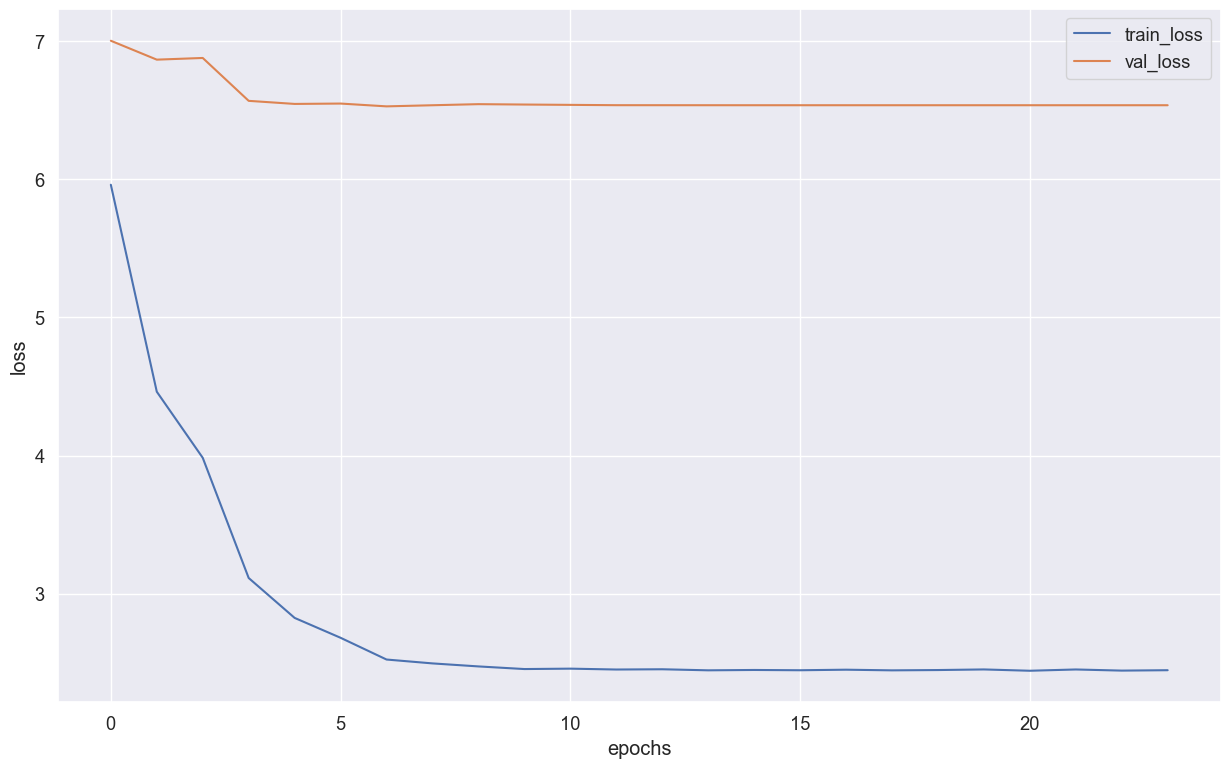

In [35]:
plt.figure(figsize=(15, 9))
plt.plot(train_losses, label="train_loss")
plt.plot(val_losses, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [56]:
for i, elem in enumerate(val_metrics):
    df = pd.DataFrame.from_dict(elem)
    df.to_csv('Epoch_{}.csv'.format(i), index=False)

np.savetxt('val_losses.txt', val_losses)

np.savetxt('train_losses.txt',train_losses)

In [36]:
torch.cuda.empty_cache()

import gc
#del variables
gc.collect()

3128

In [37]:
#torch.save(model.state_dict(), f"SSDLiteMobNet.pth")

Теперь сравним качество детектирования.

In [38]:
output = model([train_dataset[-178][0], train_dataset[-178][0]])

In [39]:
boxes = [output[i]["boxes"][output[i]["scores"] > 0.5] for i in np.arange(0, len(output), 1)]
labels = [output[i]["labels"][output[i]["scores"] > 0.5] for i in np.arange(0, len(output), 1)]

Confidence: 0.863


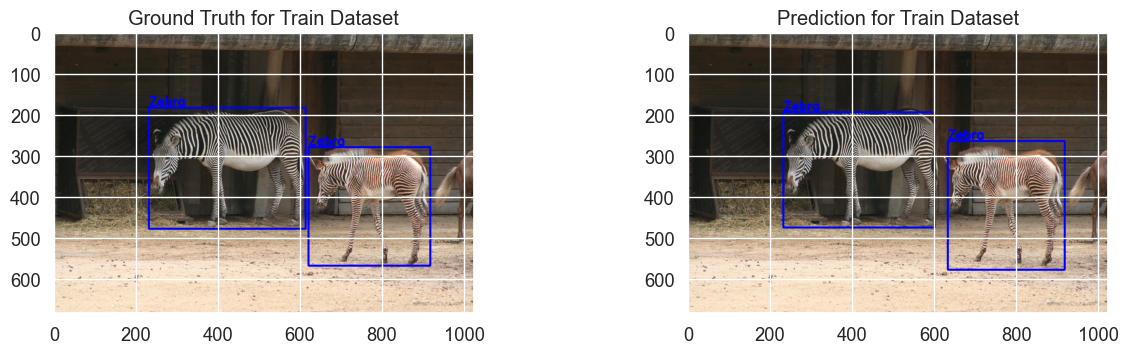

In [40]:
print("Confidence: {}".format(np.round(output[0]["scores"][0].cpu().detach().numpy(), 3)))

plt.figure(figsize=(15,8))
plt.subplot(2,2,1)
plt.imshow(get_image(train_dataset[-178][0], train_dataset[-178][1]["boxes"], train_dataset
           [-178][1]["labels"], 3, 1))
plt.title("Ground Truth for Train Dataset")

plt.subplot(2,2,2)
plt.imshow(get_image(train_dataset[-178][0], boxes[0], labels[0], 3, 1))
plt.title("Prediction for Train Dataset")
plt.show()

In [41]:
ind = -5 #1538
output = model([test_dataset[ind][0], test_dataset[ind][0]]) #1538

In [42]:
len(output[0]["boxes"])

136

In [43]:
boxes = [output[i]["boxes"][output[i]["scores"] > 0.5] for i in np.arange(0, len(output), 1)]
labels = [output[i]["labels"][output[i]["scores"] > 0.5] for i in np.arange(0, len(output), 1)]

Confidence: 0.968


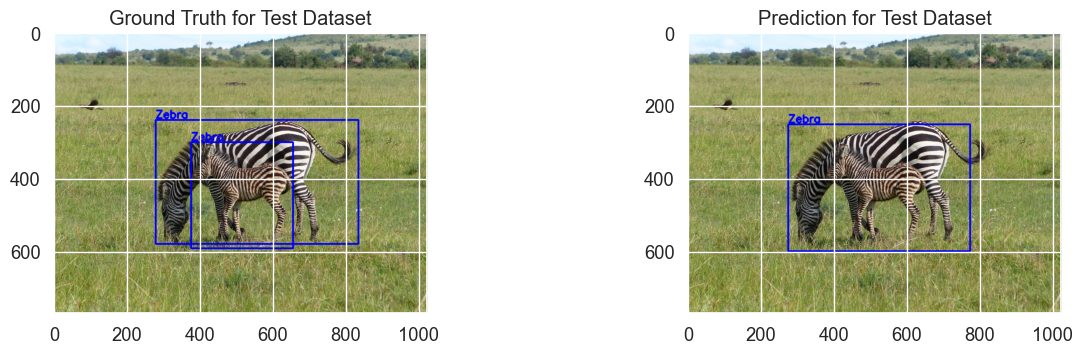

In [44]:
print("Confidence: {}".format(np.round(output[0]["scores"][0].cpu().detach().numpy(), 3)))

plt.figure(figsize=(15,8))
plt.subplot(2,2,1)
plt.imshow(get_image(test_dataset[ind][0], test_dataset[ind][1]["boxes"], test_dataset[ind][1]["labels"], 3, 1))
plt.title("Ground Truth for Test Dataset")

plt.subplot(2,2,2)
plt.imshow(get_image(test_dataset[ind][0], boxes[0], labels[0], 3, 1))
plt.title("Prediction for Test Dataset")
plt.show()

Пример применения: удобно для защиты от хищников на фермах, либо для защиты поселеней от хищников. Также можно мониторить редких животных, потому что модель хорошо находит в том числе и какие-то очень маленькие объекты на фотографии, что может помочь при наличии снимков не очень хорошего качества (но не слишком).

Дальнейшие планы: сделать детектирование по видео; оформить репозиторий на Github.